In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotstyle.export import save_timestamped_figure
from plotstyle.colors import cambridge_core
from plotstyle.size import get_dim, WIDTH

from lrdms.constants import DATA_PATH

SAVE = False

In [6]:
# General imports for all experiments
from lrdms.data.srired import IRED
from lrdms.utils.mutations import Variant
from lrdms.data.predictions import VariantPredictions
from loguru import logger

# Prepare double mutant features

Load experimental data

In [7]:
srired = IRED()

2024-05-27 12:51:11.984 | INFO     | lrdms.data.srired:_process_raw_data:44 - Remove 0 NaN sequences
2024-05-27 12:51:11.986 | INFO     | lrdms.data.srired:_process_raw_data:48 - Remove 0 NaN fitness values
2024-05-27 12:51:11.988 | INFO     | lrdms.data.srired:_process_raw_data:52 - Remove 1320 sequences not ending in stop
2024-05-27 12:51:11.995 | INFO     | lrdms.data.srired:_process_raw_data:58 - Remove 981 sequences with intermediate stop
2024-05-27 12:51:12.009 | INFO     | lrdms.data.srired:_process_raw_data:69 - Remove 0 sequences with non-standard AAs
2024-05-27 12:51:12.012 | INFO     | lrdms.data.srired:_process_raw_data:74 - Remove 15 sequences with length != 290
2024-05-27 12:51:12.015 | INFO     | lrdms.data.srired:_process_raw_data:80 - Remove 3 sequences with >15 mutations
2024-05-27 12:51:12.018 | INFO     | lrdms.data.srired:_process_raw_data:92 - Parsing variants from sequences
2024-05-27 12:51:12.117 | INFO     | lrdms.data.srired:_process_raw_data:97 - Evaluating r

Load variants from dataframes that store the pre-computed features based on the 3D structure & sequence

In [8]:
save_dir = DATA_PATH / "processed"
# Load variants with pre-computed features based on the 3D structure & sequence
singles = VariantPredictions.from_df(srired, pd.read_csv(save_dir / "singles_processed.csv", index_col=0))
doubles = VariantPredictions.from_df(srired, pd.read_csv(save_dir / "doubles_processed.csv", index_col=0))
higher = VariantPredictions.from_df(srired, pd.read_csv(save_dir / "higher_processed.csv", index_col=0))

# Turn variants into objects
for variants in [singles, doubles, higher]:
    variants.data.variant = variants.data.variant.apply(Variant.from_str)

Add single mutation features to double mutations 

In [11]:
# Add single mutation features to doubles
def _get_single_mut_features(mutant, single_features="all"):
    df = singles.data.drop(columns=["observed", "hamming_to_wildtype"]).set_index("variant")
    if single_features == "all":
        single_features = df.columns

    return df.loc[mutant, single_features]


def add_single_features(X, single_features="all"):
    n_mut = len(X.variant.iloc[0])

    original_df = [X.reset_index(drop=True)]
    mutant_feature_dfs = [
        _get_single_mut_features(X.variant.apply(lambda x: x.mutations[i]), single_features=single_features)
        .reset_index(drop=True)
        .add_suffix(f"_{i+1}")
        for i in range(n_mut)
    ]

    return pd.concat(original_df + mutant_feature_dfs, axis=1, ignore_index=False)


doubles.data = add_single_features(doubles.data)

# Split data

In [12]:
THRESHOLD = 0.0
LOW_FITNESS_CUTOFF = -5.0
FEATURES = [
    "true_fitness_min",
    "combinability_pos",
    "combinability_neg",
    "additive_fitness",
    "esm_fitness",
    "nma_msqf_min",
    "nma_msqf_max",
    "ca_ligand_dist_min",
    "catalytic_dist_min",
    "interface_dist_min",
    "esm_epi",
]
TARGET = "true_fitness"

In [14]:
import xgboost as xgb
import re
from lrdms.features.dms import CombinabilityFeaturiser


def reduce_grouped_features(X: pd.DataFrame, reduce_funcs: list[callable]) -> pd.DataFrame:
    # Get number of single-group count from highets column suffix
    n_single_groups = int(X.columns.str.extract(r"_(\d+)$").dropna().max().values[0])
    # Get single group
    single_groups = np.array(
        [sorted([col for col in X.columns if re.search(rf"_{i+1}$", col)]) for i in range(n_single_groups)]
    )
    # Get all columns that don't have a number suffix
    combined_groups = [col for col in X.columns if not re.search(r"_\d+$", col)]
    # For each reduce function, apply to each single group
    df = X[combined_groups].copy()
    for reduce in reduce_funcs:
        for feature in single_groups.T:
            feature_name = feature[0].rsplit("_", 1)[0] + f"_{reduce.__name__}"
            df.loc[:, feature_name] = reduce(X[feature], axis=1)
    return df


class CombinabilityModel:
    def __init__(
        self,
        model: xgb.XGBModel,
        wt_seq_len=srired.sequence_length,
        aggr_funcs=[np.mean, np.max, np.min],
        features_to_use: list[str] = FEATURES,
    ):
        self.model = model
        self.wt_seq_len = wt_seq_len
        self.aggr_funcs = aggr_funcs
        self.combinability_featuriser = CombinabilityFeaturiser(seq_len=wt_seq_len)
        self.features_to_use = features_to_use

    def prepare_features(self, X):
        # Add combinability features to X
        X_featurised = self.combinability_featuriser.transform(X)
        X_featurised = reduce_grouped_features(X_featurised, self.aggr_funcs)

        # Add esm_epi feature
        if "esm_epi" in self.features_to_use:
            X_featurised["esm_epi"] = (
                X_featurised["esm_fitness"] - X_featurised["esm_fitness_min"] - X_featurised["esm_fitness_max"]
            )
        return X_featurised[self.features_to_use]

    def fit(self, X, y, combinability_data, **model_fit_kwargs):
        # Fit combinability features
        # TODO: Think about whether to exclude any combinability data which do not contain at least one mutation in X
        self.combinability_featuriser.fit(combinability_data)

        # Prepare features
        X_featurised = self.prepare_features(X)

        # PATCH: Featurise eval_set
        if "eval_set" in model_fit_kwargs:
            _updated_eval_set = []
            for eval_set in model_fit_kwargs["eval_set"]:
                X_eval, y_eval = eval_set
                X_eval_featurised = self.prepare_features(X_eval)
                _updated_eval_set.append((X_eval_featurised, y_eval))
            model_fit_kwargs["eval_set"] = _updated_eval_set
        ### END PATCH

        # Fit model
        self.model.fit(X_featurised, y, **model_fit_kwargs)

    def predict(self, X):
        # Prepare features
        X_featurised = self.prepare_features(X)

        # Predict
        return self.model.predict(X_featurised)

In [15]:
combinability_all = pd.concat([doubles.data.query("observed"), higher.data])[["variant", "true_fitness"]]

train_ids = set(doubles.data.query("observed").sample(frac=0.8, random_state=42).variant.values)
test_ids = set(doubles.data.query("observed").variant.values) - train_ids

train_data = doubles.data.query("(variant in @train_ids) & (true_fitness > -inf)").copy()
train_data["potentially_useful"] = train_data.true_fitness > THRESHOLD

# Check data balance (NOTE: The way it's implmented actually leaks a tiny bit from val ...)
true_count = train_data.potentially_useful.sum()
false_count = (~train_data.potentially_useful).sum()
pos_to_neg_ratio = true_count / false_count
print(f"Positive to negative ratio: {pos_to_neg_ratio:.2f}")
weights = np.where(train_data.potentially_useful, 1 / true_count, 1 / false_count)
weights /= weights.mean()
train_data["sample_weight"] = weights

# Split into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop(columns=["true_fitness", "observed", "hamming_to_wildtype", "potentially_useful"]),
    train_data.true_fitness.clip(LOW_FITNESS_CUTOFF),
    test_size=0.2,
    random_state=42,
)

# Get variants to exclude from combinability calculation (val & test)
exclude_for_combinability = set(X_val.variant.values).union(test_ids)

sample_weights_train = X_train.pop("sample_weight")
sample_weights_val = X_val.pop("sample_weight")

xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",  # rank:pairwise
    # objective="rank:pairwise",
    booster="gbtree",
    random_state=42,
    seed=42,
    # sample_pos_weight=false_count / true_count,
    scale_pos_weight=4.630490956072351,
    gamma=0.5,
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    # eta=0.1,
)

model = CombinabilityModel(xgb_model)
model.fit(
    X_train[y_train > LOW_FITNESS_CUTOFF],
    y_train[y_train > LOW_FITNESS_CUTOFF],
    combinability_all.query("variant not in @exclude_for_combinability"),
    sample_weight=sample_weights_train,
    eval_set=[(X_val, y_val > 0.0)],
    eval_metric="aucpr",
    sample_weight_eval_set=[sample_weights_val],
)

Positive to negative ratio: 0.22


2024-05-27 12:53:24.428 | INFO     | lrdms.features.dms:fit:138 - Combinability calculated.


[0]	validation_0-aucpr:0.69150
[1]	validation_0-aucpr:0.70550
[2]	validation_0-aucpr:0.70259
[3]	validation_0-aucpr:0.69923
[4]	validation_0-aucpr:0.70244
[5]	validation_0-aucpr:0.69435
[6]	validation_0-aucpr:0.69280
[7]	validation_0-aucpr:0.69493
[8]	validation_0-aucpr:0.69996
[9]	validation_0-aucpr:0.70622
[10]	validation_0-aucpr:0.70586
[11]	validation_0-aucpr:0.70498
[12]	validation_0-aucpr:0.70707
[13]	validation_0-aucpr:0.70518
[14]	validation_0-aucpr:0.70398
[15]	validation_0-aucpr:0.70058
[16]	validation_0-aucpr:0.70228
[17]	validation_0-aucpr:0.70200
[18]	validation_0-aucpr:0.70245
[19]	validation_0-aucpr:0.70219
[20]	validation_0-aucpr:0.70082
[21]	validation_0-aucpr:0.70055
[22]	validation_0-aucpr:0.69695
[23]	validation_0-aucpr:0.69275
[24]	validation_0-aucpr:0.69255
[25]	validation_0-aucpr:0.68923
[26]	validation_0-aucpr:0.68903
[27]	validation_0-aucpr:0.69203
[28]	validation_0-aucpr:0.68912
[29]	validation_0-aucpr:0.68750
[30]	validation_0-aucpr:0.68603
[31]	validation_0-

/opt/homebrew/Caskroom/miniconda/base/envs/lrdms/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


# Replication

In [16]:
# Full run with all data

xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",  # rank:pairwise
    # objective="rank:pairwise",
    booster="gbtree",
    random_state=42,
    seed=42,
    # sample_pos_weight=false_count / true_count, # NOTE: These weirdly enough seem to have no effect
    # scale_pos_weight=4.630490956072351,  # NOTE: These weirdly enough seem to have no effect
    # sample_pos_weight=false_count / true_count,
    gamma=0.5,
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    # eta=0.1,
)

X_all = doubles.data.query("observed & (true_fitness > -inf)")
y_all = X_all.true_fitness

# Compute weights to balance data
weights = np.where(y_all > 0, 1.0 / true_count, 1.0 / false_count)
weights /= weights.mean()

model = CombinabilityModel(
    model=xgb_model, wt_seq_len=srired.sequence_length, features_to_use=FEATURES, aggr_funcs=[np.mean, np.min, np.max]
)

model.fit(X_all, y_all.clip(LOW_FITNESS_CUTOFF), combinability_all, sample_weight=weights)

X_pred = doubles.data.query("~observed")
predictions = model.prepare_features(X_pred)
predictions["variant"] = X_pred["variant"]
predictions["predicted_fitness"] = model.predict(X_pred)

# Log top 100 suggestions
best_suggestions = predictions.sort_values(["predicted_fitness"], ascending=False).head(100)
best_suggestions[["variant", "predicted_fitness", *FEATURES]]

2024-05-27 12:53:33.187 | INFO     | lrdms.features.dms:fit:138 - Combinability calculated.


,variant,predicted_fitness,true_fitness_min,combinability_pos,combinability_neg,additive_fitness,esm_fitness,nma_msqf_min,nma_msqf_max,ca_ligand_dist_min,catalytic_dist_min,interface_dist_min,esm_epi
190567,"Q41P,T241A",2.012847,0.340881,43,174,2.174347,5.789338,0.066425,0.187677,4.806287,6.800161,6.800161,0.020360
190570,"Q41P,T241S",2.012847,0.340881,43,174,1.029879,4.062568,0.066425,0.187677,4.806287,6.800161,6.800161,0.009115
165276,"E36A,T241A",2.007645,-0.563793,47,223,1.269673,4.261448,0.066425,0.187677,4.806287,6.800161,6.800161,0.026353
157036,"S35T,S51G",1.943239,-0.189081,51,264,-0.325901,2.831058,0.182866,0.187677,3.744922,19.871347,17.774124,0.061410
160174,"S35T,T241A",1.904967,-0.189081,48,175,1.644384,2.694601,0.066425,0.187677,3.744922,6.800161,6.800161,0.004707
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191268,"Q41P,I283F",1.352040,0.340881,24,215,0.705328,2.757790,0.047295,0.187677,14.502118,12.562528,5.452036,0.011480
161729,"E36A,S68L",1.351907,-0.563793,27,244,-0.474005,2.581248,0.092022,0.187677,3.986063,7.145299,7.730457,-0.058642
164669,"E36A,T213S",1.350263,-0.563793,26,220,-0.285920,3.879339,0.067306,0.187677,7.404692,12.010876,5.637770,-0.024137
163996,"E36A,T180A",1.349336,-0.563793,33,264,-0.654294,3.147397,0.047888,0.187677,7.404692,5.446994,4.971477,-0.009563


# Shap value explanations

In [26]:
from plotstyle.patch import patch_plot


def _apply_plotstyle(style="nature", figsize=WIDTH.nature_column):
    # adapt plot style and fig size
    fig, ax = patch_plot(style=style, figsize=figsize)

    # get y-label of current axis
    y_tick_labels = [item.get_text() for item in ax.get_yticklabels()]
    # set list of strings as labels
    ax.set_yticklabels(
        [
            label.replace("_", " ")
            .capitalize()
            .replace("Esm", "ESM")
            .replace("Nma", "NMA")
            .replace("esm", "ESM")
            .replace("nma", "NMA")
            for label in y_tick_labels
        ]
    )

    return fig, ax


def _save_shap_for_publication(name, save=True, save_dir=SAVE_DIR):
    _apply_plotstyle("nature", WIDTH.nature_column)
    if save:
        save_timestamped_figure(name + "_1col", save_dir=SAVE_DIR)
    _apply_plotstyle("nature", WIDTH.nature_2column)
    if save:
        save_timestamped_figure(name + "_2col", save_dir=SAVE_DIR)
    plt.show()

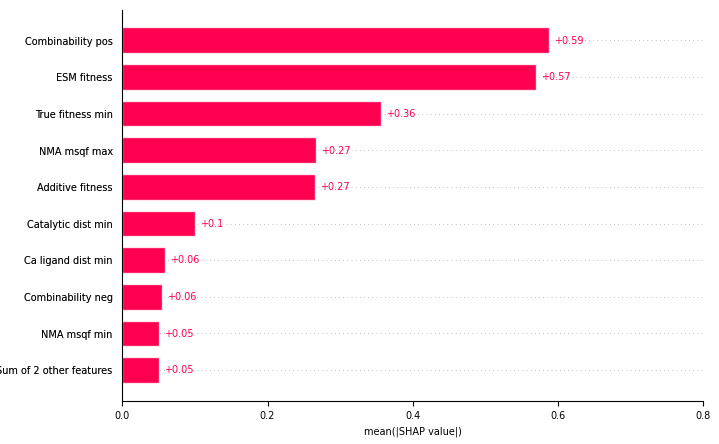

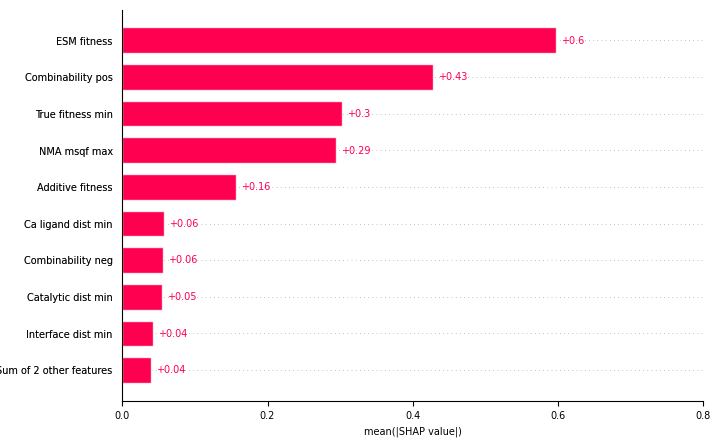

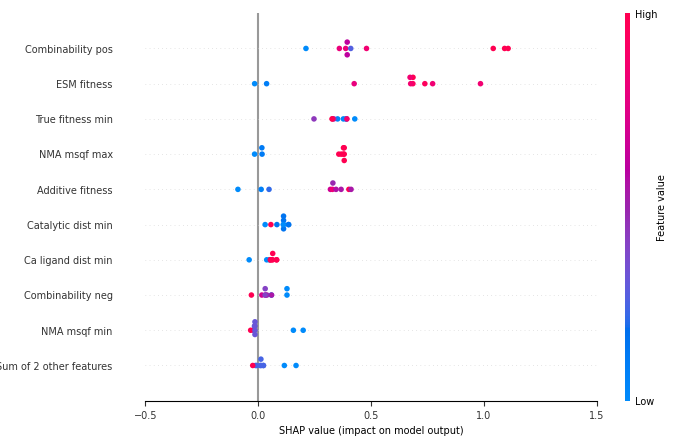

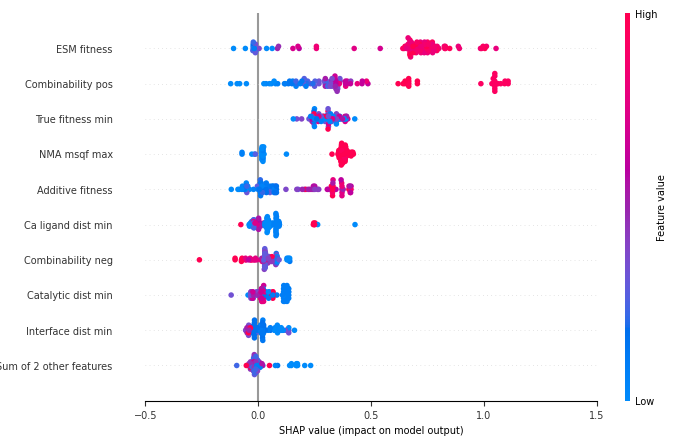

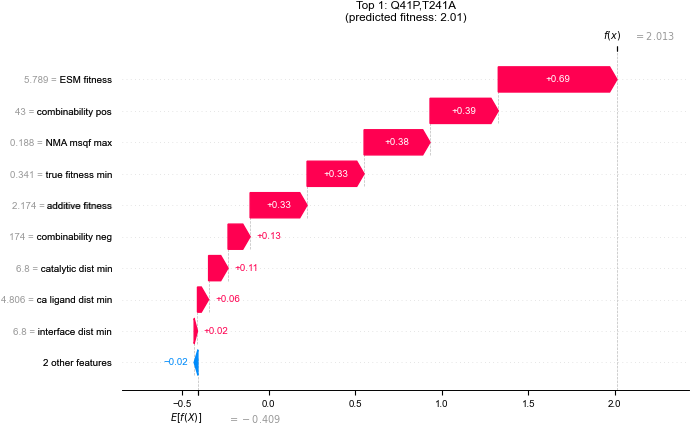

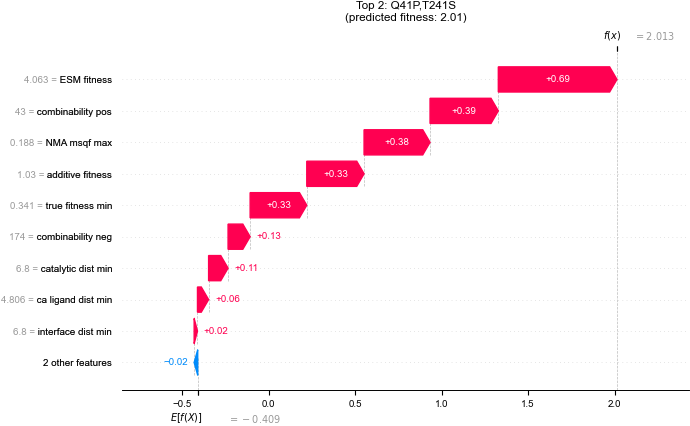

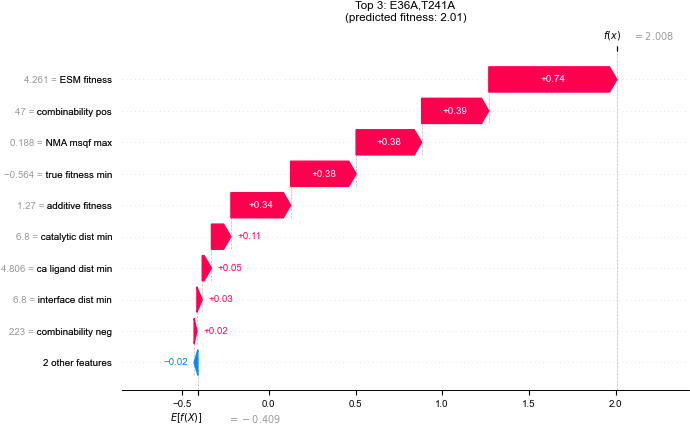

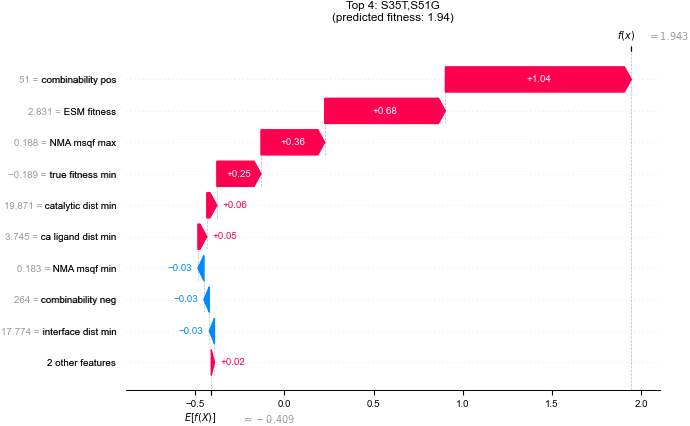

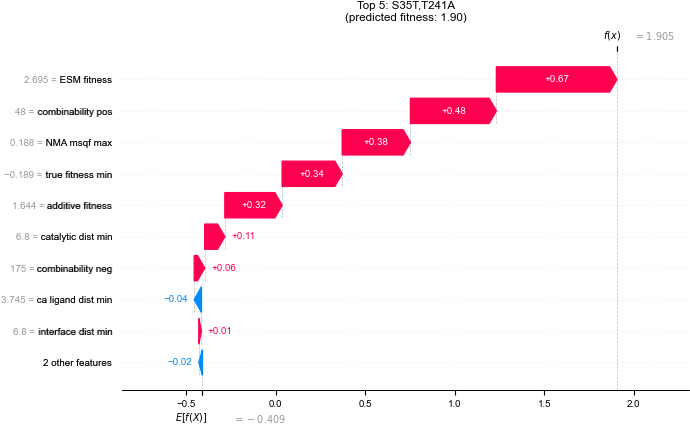

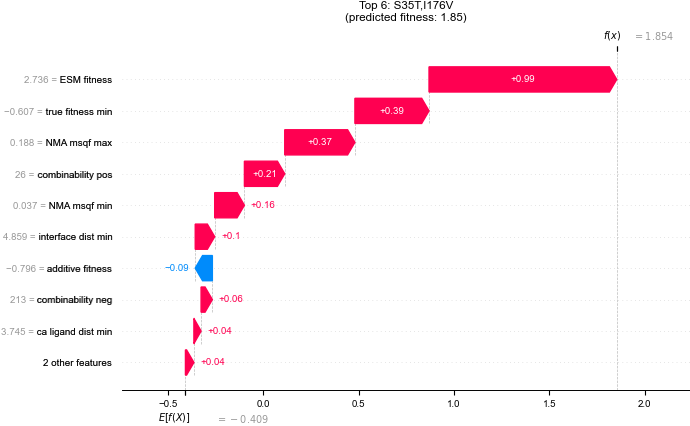

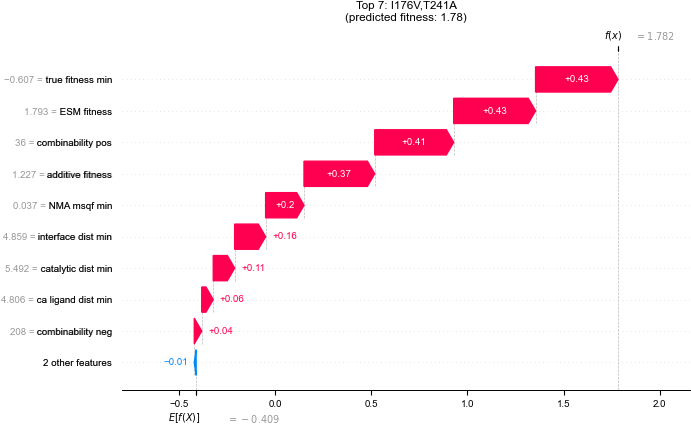

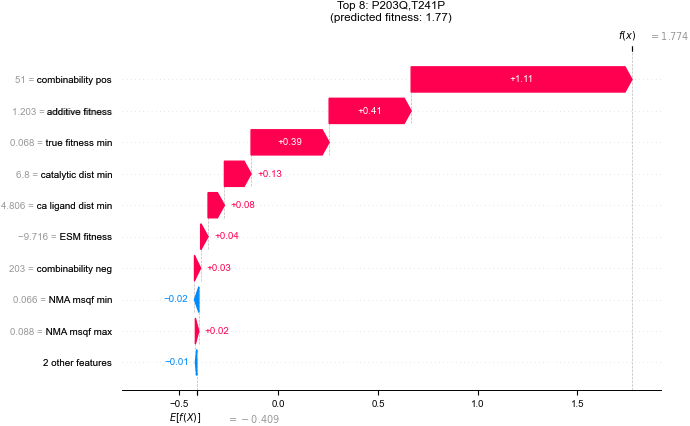

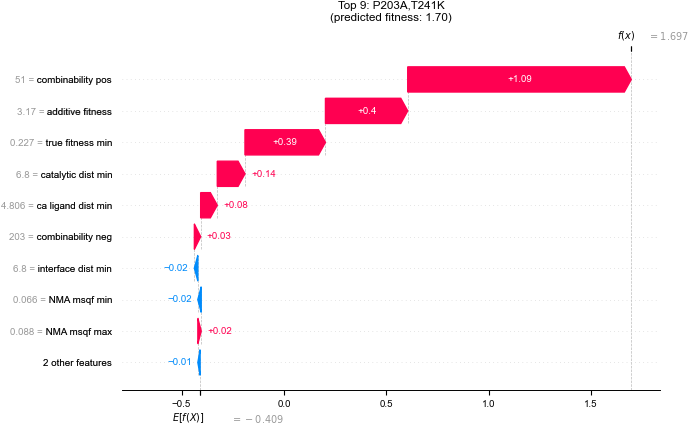

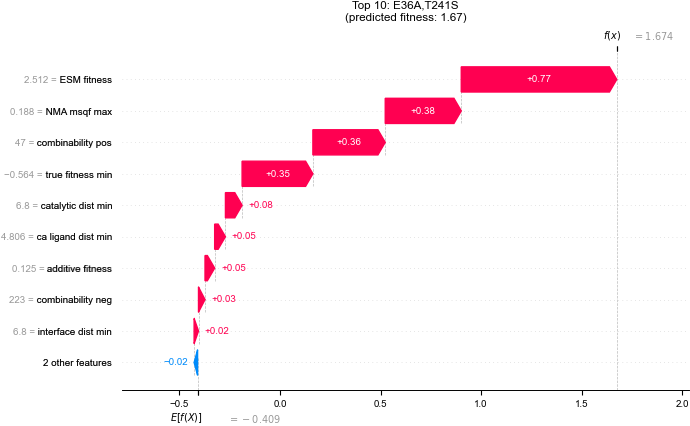

In [27]:
import shap

feature_names = [f.replace("_", " ").capitalize().replace("Esm", "ESM").replace("Nma", "NMA") for f in FEATURES]
explainer = shap.TreeExplainer(model.model, feature_names=feature_names)
shap_values = explainer(best_suggestions[FEATURES])

shap.plots.bar(shap_values[:10], max_display=10, show=False)
_save_shap_for_publication("feature_importance_shap_bar_top10", save=SAVE)

shap.plots.bar(shap_values, max_display=10, show=False)
_save_shap_for_publication("feature_importance_shap_bar_top100", save=SAVE)

shap.plots.beeswarm(shap_values[:10], show=False)
_save_shap_for_publication("feature_importance_shap_beeswarm_top10", save=SAVE)

shap.plots.beeswarm(shap_values, show=False)
_save_shap_for_publication("feature_importance_shap_beeswarm_top100", save=SAVE)

# And for individual variants
for i in range(10):
    with plt.style.context("nature"):
        shap.plots.waterfall(shap_values[i], max_display=10, show=False)
        plt.title(
            f"Top {i+1}: {best_suggestions.variant.iloc[i]}\n(predicted fitness: {best_suggestions.predicted_fitness.iloc[i]:.2f})"
        )
        _save_shap_for_publication(f"feature_importance_shap_waterfall_top{i+1}", save=SAVE)

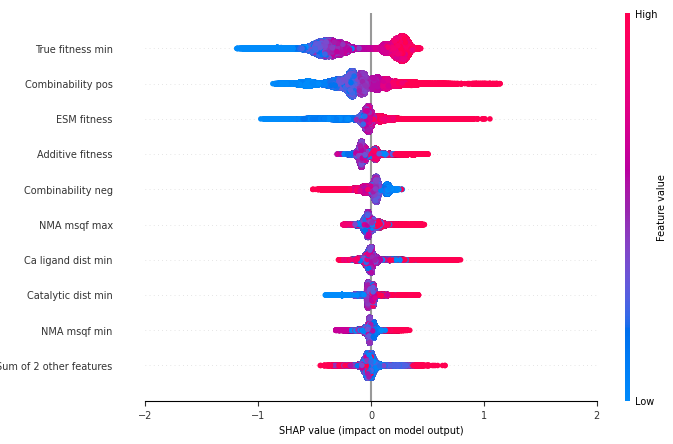

In [22]:
shap_values_all = explainer(predictions[FEATURES])
shap.plots.beeswarm(shap_values_all, show=False)
_save_shap_for_publication("feature_importance_shap_beeswarm_all_doubles", save=SAVE)

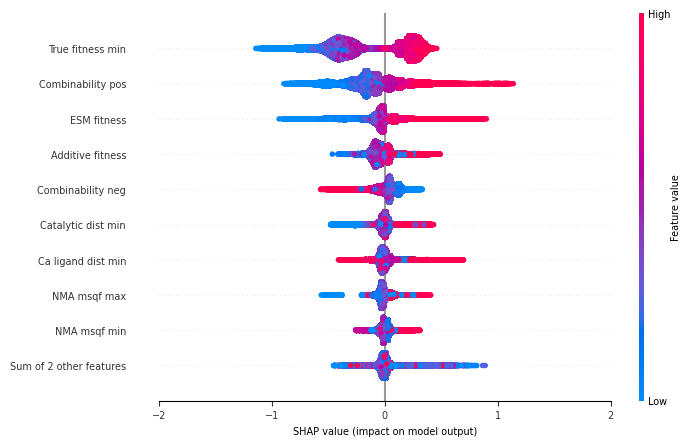

In [207]:
_save_shap_for_publication("feature_importance_shap_beeswarm_all_doubles", save=SAVE)

# Learning curves

In [344]:
# TODO: Export to utils
from typing import Callable

# Set up cross-validator
from sklearn.model_selection import KFold
from sklearn.utils import shuffle as shuffle_data
from logging import getLogger

logger = getLogger(__name__)

# Well plate sizes
WELL_PLATE_SIZES = [12, 24, 48, 96, 2 * 96, 3 * 96, 384, 2 * 384, 3 * 384, 1536, 2 * 1536, 3 * 1536]
WELL_PLATE_SIZES_TICKS = [12, 24, 48, 96, 2 * 96, 384, 2 * 384, 1536, 2 * 1536]


# Set up metrics
from src.evaluation.metrics import ndcg_at_k, precision_at_k
from src.evaluation.hsu_metrics import spearman, topk_mean, hit_rate

METRICS = [
    spearman,
    named_partial(ndcg_at_k, k=10, name="top10_ndcg"),
    named_partial(ndcg_at_k, k=100, name="top100_ndcg"),
    named_partial(precision_at_k, k=10, name="top10_precision"),
    named_partial(topk_mean, topk=10, name="top10_mean"),
    named_partial(hit_rate, topk=10, name="top10_hit_rate"),
]


def compute_learning_curves(
    X,
    y,
    combinability_all,
    model,
    metrics: Callable | list[Callable] = METRICS,
    sizes: list[int | float] = WELL_PLATE_SIZES,
    cv=KFold(n_splits=10, shuffle=True, random_state=7),
    shuffle: bool = True,
    random_state: int = 7,
    store_predictions: bool = False,
    stratify_bins: int | None = 10,
):
    output = {}

    # If groups is an integer N and y continuous, then bin y into N groups
    if (y.dtype in [np.float32, np.float64]) and (isinstance(stratify_bins, int)):
        bins = np.digitize(y, bins=np.linspace(y.min(), y.max(), stratify_bins))
    else:
        bins = y

    cv_iter = list(cv.split(X, bins))
    cv_subset_size = [len(cv_train_subset) for cv_train_subset, _ in cv_iter]
    cv_min_size = min(cv_subset_size)

    if cv_min_size < max(sizes):
        logger.warning(f"Dropping sizes > {cv_min_size} (smallest cross-validation subset size)")
        sizes = [s for s in sizes if s <= cv_min_size]
        sizes += [cv_min_size]

    if shuffle:
        X, y = shuffle_data(X, y, random_state=random_state)  # returns shuffled copies

    if not isinstance(metrics, list):
        metrics = [metrics]

    # Outer loop: iterate over the cross-validation splits
    for cv_idx, (train_idxs, test_idxs) in enumerate(cv_iter):
        output[f"cv{cv_idx}"] = {}
        cv_result = output[f"cv{cv_idx}"]
        cv_result["train_size"] = len(train_idxs) + len(test_idxs)
        cv_result["test_size"] = len(test_idxs)
        cv_result["train_propotion"] = len(train_idxs) / (len(train_idxs) + len(test_idxs))

        # Shuffle combinability data
        combinability_all = (
            combinability_all.copy().sample(frac=1, random_state=cv_idx + random_state).reset_index(drop=True)
        )

        # Inner loop: iterate over the different dataset sizes
        for size in sizes:
            cv_result[f"{size}"] = {}
            cv_result[f"{size}"]["train_size"] = size
            proportion = size / len(train_idxs)

            ### PATCH: Combinability specific
            # Get the training and test sets
            X_train, X_test = X.iloc[train_idxs[:size], :], X.iloc[test_idxs, :]
            y_train, y_test = y.iloc[train_idxs[:size]], y.iloc[test_idxs]

            # Deal with combinability data
            _missing_X_train_ids = set(X.variant.values[train_idxs[size:]])
            _X_test_ids = set(X_test.variant.values)
            exclude_for_combinability = _missing_X_train_ids.union(_X_test_ids)
            combinability_data = combinability_all.query("variant not in @exclude_for_combinability").copy()

            combinability_data = combinability_data.iloc[: int(round(proportion * len(combinability_data), 0)), :]
            cv_result[f"{size}"]["combinability_size"] = len(combinability_data)

            # Fit the model
            model.fit(X_train, y_train, combinability_data)
            ### END PATCH

            # Compute the predictions
            y_pred = model.predict(X_test)

            if store_predictions:
                cv_result[f"{size}"]["y_pred"] = y_pred
                cv_result[f"{size}"]["y_test"] = y_test.values

            # Compute the metrics
            for metric in metrics:
                cv_result[f"{size}"][metric.__name__] = metric(y_true=y_test.values, y_pred=y_pred)

    # Average over the cross-validation splits
    output["result_stats"] = {}
    for size in sizes:
        output["result_stats"][f"{size}"] = {}
        result_stats = output["result_stats"][f"{size}"]
        for metric in metrics:
            result_stats[metric.__name__] = {}
            result_stats_for_metric = result_stats[metric.__name__]
            result_stats_for_metric["mean"] = np.mean(
                [output[f"cv{i}"][f"{size}"][metric.__name__] for i in range(cv.get_n_splits())]
            )
            result_stats_for_metric["std"] = np.std(
                [output[f"cv{i}"][f"{size}"][metric.__name__] for i in range(cv.get_n_splits())]
            )
            result_stats_for_metric["med"] = np.median(
                [output[f"cv{i}"][f"{size}"][metric.__name__] for i in range(cv.get_n_splits())]
            )
            result_stats_for_metric["q25"] = np.quantile(
                [output[f"cv{i}"][f"{size}"][metric.__name__] for i in range(cv.get_n_splits())], 0.25
            )
            result_stats_for_metric["q75"] = np.quantile(
                [output[f"cv{i}"][f"{size}"][metric.__name__] for i in range(cv.get_n_splits())], 0.75
            )

    return output

In [345]:
combinability_all["hamming_to_wildtype"] = combinability_all.variant.apply(len)
# highers = combinability_all.query("hamming_to_wildtype > 2")
# # def _get_number_of_observed_doubles_in_higher_order_variants(variant: Variant, observed_doubles: list[Variant] = combinability_all.query("hamming_to_wildtype == 2").variant.values):
# #     return sum([observed_double in variant for observed_double in observed_doubles])
# # highers["contained_doubles"] = highers.variant.apply(_get_number_of_observed_doubles_in_higher_order_variants)

# # highers.contained_doubles.value_counts()
# # # contained_doubles
# # # 0    5795
# # # 1     198
# # # 2      83
# # # 4       4
# # # 3       3
# # # Name: count, dtype: int64

# # # p(higher_order_observed | no_double_observed) = 0.95
# # p_hnd = len(highers.query("contained_doubles == 0")) / len(highers)

# # # p(higher_order which contains observed double) = 0.057
# # 290 / len(combinability_all.query("hamming_to_wildtype == 2"))

# len(highers.query("contained_doubles > 0")) / len(doubles.data.query("observed"))  # 0.074

In [346]:
def compute_esm_learning_curves(
    X,
    y,
    model,
    metrics: Callable | list[Callable],
    sizes: list[int | float] = WELL_PLATE_SIZES,
    cv=KFold(n_splits=10, shuffle=True, random_state=7),
    shuffle: bool = True,
    random_state: int = 7,
    X_wt=None,
    y_wt=None,
    store_predictions: bool = False,
    stratify_bins: int = 10,
):
    output = {}

    # If groups is an integer N and y continuous, then bin y into N groups
    if (y.dtype in [np.float32, np.float64]) and (isinstance(stratify_bins, int)):
        bins = np.digitize(y, bins=np.linspace(y.min(), y.max(), stratify_bins))
    else:
        bins = y

    cv_iter = list(cv.split(X, bins))
    cv_subset_size = [len(cv_train_subset) for cv_train_subset, _ in cv_iter]
    cv_min_size = min(cv_subset_size)

    if cv_min_size < max(sizes):
        logger.warning(f"Dropping sizes > {cv_min_size} (smallest cross-validation subset size)")
        sizes = [s for s in sizes if s <= cv_min_size]
        sizes += [cv_min_size]

    if shuffle:
        X, y = shuffle_data(X, y, random_state=random_state)  # returns shuffled copies

    if not isinstance(metrics, list):
        metrics = [metrics]

    # Outer loop: iterate over the cross-validation splits
    for cv_idx, (train_idxs, test_idxs) in enumerate(cv_iter):
        output[f"cv{cv_idx}"] = {}
        cv_result = output[f"cv{cv_idx}"]
        cv_result["train_size"] = len(train_idxs) + len(test_idxs)
        cv_result["test_size"] = len(test_idxs)

        # Inner loop: iterate over the different dataset sizes
        for size in sizes:
            cv_result[f"{size}"] = {}
            cv_result["train_propotion"] = len(train_idxs) / (len(train_idxs) + len(test_idxs))

            # Get the training and test sets
            X_train, X_test = X[train_idxs[:size]], X[test_idxs]
            y_train, y_test = y[train_idxs[:size]], y[test_idxs]

            # Append the wildtype data to the training set
            if exists(X_wt) and exists(y_wt):
                X_train = np.concatenate([X_train, np.atleast_1d(X_wt)])
                y_train = np.concatenate([y_train, np.atleast_1d(y_wt)])

            # Fit the model
            model.fit(X_train, y_train)

            # Compute the predictions
            y_pred = model.predict(X_test)

            if store_predictions:
                cv_result[f"{size}"]["y_pred"] = y_pred
                cv_result[f"{size}"]["y_test"] = y_test

            # Compute the metrics
            for metric in metrics:
                cv_result[f"{size}"][metric.__name__] = metric(y_true=y_test, y_pred=y_pred)

    # Average over the cross-validation splits
    output["result_stats"] = {}
    for size in sizes:
        output["result_stats"][f"{size}"] = {}
        result_stats = output["result_stats"][f"{size}"]
        for metric in metrics:
            result_stats[metric.__name__] = {}
            result_stats_for_metric = result_stats[metric.__name__]
            result_stats_for_metric["mean"] = np.mean(
                [output[f"cv{i}"][f"{size}"][metric.__name__] for i in range(cv.get_n_splits())]
            )
            result_stats_for_metric["std"] = np.std(
                [output[f"cv{i}"][f"{size}"][metric.__name__] for i in range(cv.get_n_splits())]
            )
            result_stats_for_metric["med"] = np.median(
                [output[f"cv{i}"][f"{size}"][metric.__name__] for i in range(cv.get_n_splits())]
            )
            result_stats_for_metric["q25"] = np.quantile(
                [output[f"cv{i}"][f"{size}"][metric.__name__] for i in range(cv.get_n_splits())], 0.25
            )
            result_stats_for_metric["q75"] = np.quantile(
                [output[f"cv{i}"][f"{size}"][metric.__name__] for i in range(cv.get_n_splits())], 0.75
            )

    return output

In [347]:
from sklearn.model_selection import RepeatedKFold

In [348]:
# CV = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=7)
CV = RepeatedKFold(n_splits=5, n_repeats=6, random_state=7)

from src.models.base import LookUpPredictor
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

doubles_for_esm = doubles.data.query("observed").copy()
doubles_for_esm["seq"] = doubles_for_esm.variant.apply(lambda x: x.get_sequence(srired.wildtype_seq))


esm_performances = compute_esm_learning_curves(
    X=doubles_for_esm.seq.values,
    y=doubles_for_esm.true_fitness.values.clip(LOW_FITNESS_CUTOFF),
    model=LookUpPredictor(doubles_for_esm.set_index("seq")["esm_fitness"].to_dict(), reg_coef=1e-6),
    sizes=WELL_PLATE_SIZES[:1],
    metrics=METRICS,
    store_predictions=False,
    cv=CV,
    random_state=7,
    shuffle=True,
)

In [349]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

output = compute_learning_curves(
    doubles.data.query("observed"),
    doubles.data.query("observed").true_fitness.clip(LOW_FITNESS_CUTOFF),
    combinability_all,
    model,
    cv=CV,
    random_state=7,
)

In [350]:
esm_ablation = compute_learning_curves(
    doubles.data.query("observed"),
    doubles.data.query("observed").true_fitness.clip(LOW_FITNESS_CUTOFF),
    combinability_all,
    model=CombinabilityModel(
        model=xgb_model,
        wt_seq_len=srired.sequence_length,
        features_to_use=[f for f in FEATURES if not f.startswith("esm")],
        aggr_funcs=[np.mean, np.min, np.max],
    ),
    cv=CV,
    random_state=7,
)

In [351]:
comb_ablation = compute_learning_curves(
    doubles.data.query("observed"),
    doubles.data.query("observed").true_fitness.clip(LOW_FITNESS_CUTOFF),
    combinability_all,
    model=CombinabilityModel(
        model=xgb_model,
        wt_seq_len=srired.sequence_length,
        features_to_use=[f for f in FEATURES if not f.startswith("combinability")],
        aggr_funcs=[np.mean, np.min, np.max],
    ),
    cv=CV,
    random_state=7,
)

In [352]:
# Get ESM zero-shot performance
ESM_ZERO_SHOT = {
    name: metric(
        y_true=doubles.data.query("observed")["true_fitness"].values,
        y_pred=doubles.data.query("observed")["esm_fitness"].values,
    )
    for name, metric in zip([m.__name__ for m in METRICS], METRICS)
}

invalid value encountered in subtract


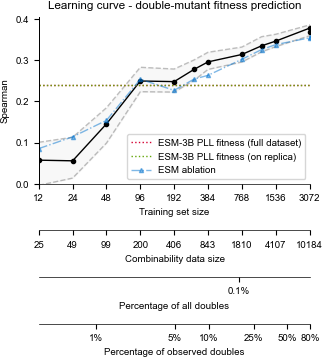

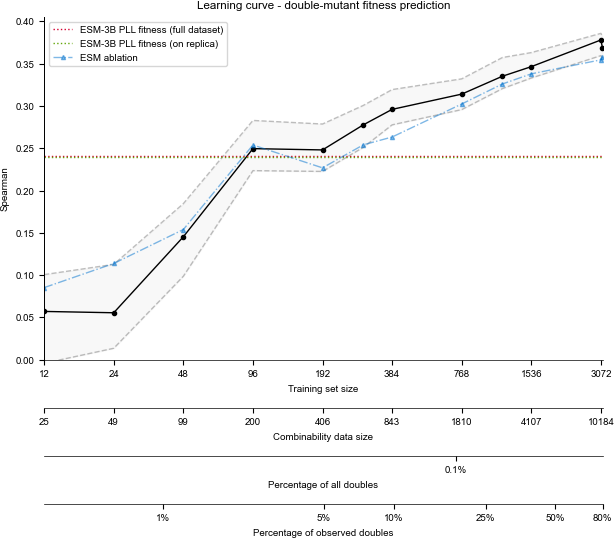

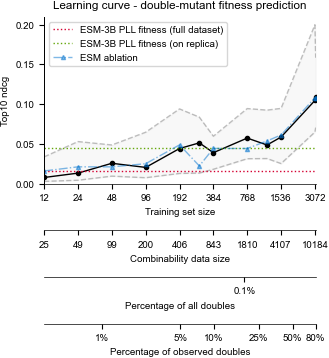

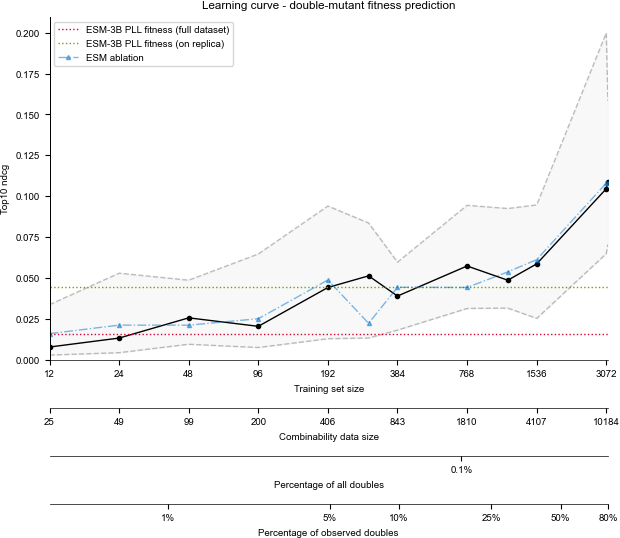

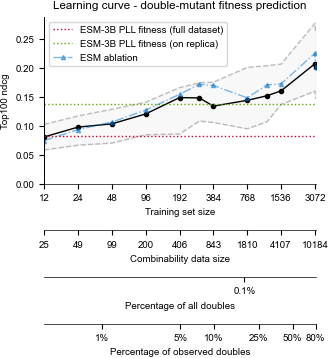

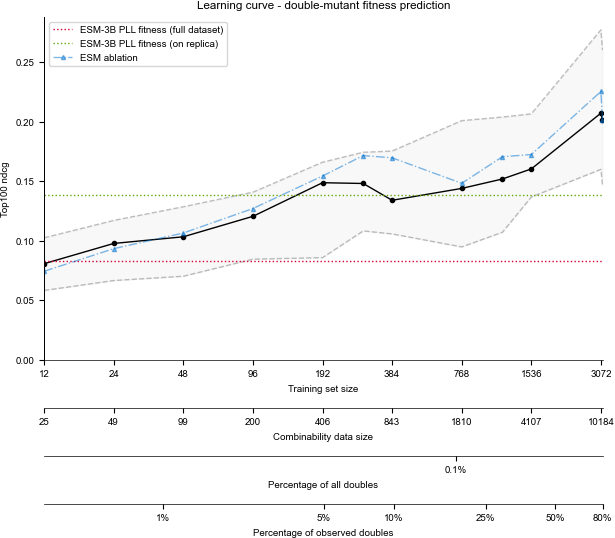

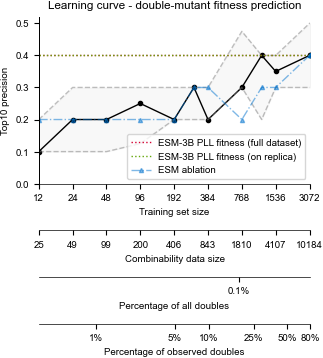

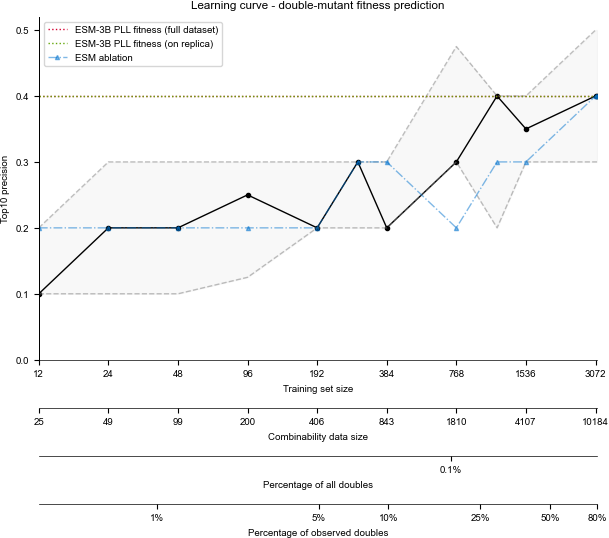

In [369]:
SAVE = False
percentages = [0.1, 1, 5, 10, 25, 50, 80]

for metric in ["spearman", "top10_ndcg", "top100_ndcg", "top10_precision"]:
    # Extract the data for plotting
    keys = []
    combs = {}
    medians, q25s, q75s = [], [], []
    for key, value in output["result_stats"].items():
        keys.append(int(key))
        medians.append(value[metric]["med"])
        q25s.append(value[metric]["q25"])
        q75s.append(value[metric]["q75"])
        combs[int(key)] = output["cv0"][key]["combinability_size"]
    keys = np.array(keys)
    medians = np.array(medians)
    q25s = np.array(q25s)
    q75s = np.array(q75s)

    keys_esm_ablation = []
    medians_esm_ablation, q25s_esm_ablation, q75s_esm_ablation = [], [], []
    for key, value in esm_ablation["result_stats"].items():
        keys_esm_ablation.append(int(key))
        medians_esm_ablation.append(value[metric]["med"])
        q25s_esm_ablation.append(value[metric]["q25"])
        q75s_esm_ablation.append(value[metric]["q75"])
    keys_esm_ablation = np.array(keys_esm_ablation)
    medians_esm_ablation = np.array(medians_esm_ablation)
    q25s_esm_ablation = np.array(q25s_esm_ablation)
    q75s_esm_ablation = np.array(q75s_esm_ablation)

    keys_comb_ablation = []
    medians_comb_ablation, q25s_comb_ablation, q75s_comb_ablation = [], [], []
    for key, value in comb_ablation["result_stats"].items():
        keys_comb_ablation.append(int(key))
        medians_comb_ablation.append(value[metric]["med"])
        q25s_comb_ablation.append(value[metric]["q25"])
        q75s_comb_ablation.append(value[metric]["q75"])
    keys_comb_ablation = np.array(keys_comb_ablation)
    medians_comb_ablation = np.array(medians_comb_ablation)
    q25s_comb_ablation = np.array(q25s_comb_ablation)
    q75s_comb_ablation = np.array(q75s_comb_ablation)

    # 1 column figure
    with plt.style.context(["nature"]):
        for _i, width in enumerate([WIDTH.nature_column]):
            _i += 1
            fig, ax = plt.subplots(figsize=get_dim(width=width))

            # Special case for ESM
            ax.plot(keys, medians, "ko-")
            # ax.errorbar(keys, medians, yerr=[medians-q25s, q75s-medians], fmt="none", ecolor="k")
            ax.semilogx()
            ax.fill_between(keys, q25s, q75s, alpha=0.05, color="gray")
            ax.plot(keys, q25s, color="gray", alpha=0.5, linestyle="--")
            ax.plot(keys, q75s, color="gray", alpha=0.5, linestyle="--")
            ax.set_xlabel("Training set size")
            # Remove old ticks
            ax.set_xticks([], minor=True)
            # Set new ticks
            ax.set_xticks(WELL_PLATE_SIZES_TICKS, minor=False)
            ax.set_xticklabels(WELL_PLATE_SIZES_TICKS, rotation=-00)
            ax.set_ylabel(metric.capitalize().replace("_", " "))
            ax.set_ylim(0, None)
            ax.set_xlim(WELL_PLATE_SIZES_TICKS[0], keys[-1] + 1)

            # Add ESM zero-shot performance on entire dataset
            ax.axhline(
                ESM_ZERO_SHOT[metric],
                color=cambridge_core[0],
                linestyle="dotted",
                alpha=1,
                label="ESM-3B PLL fitness (full dataset)",
            )
            ax.axhline(
                esm_performances["result_stats"][str(WELL_PLATE_SIZES[0])][metric]["med"],
                color=cambridge_core[3],
                linestyle="dotted",
                label="ESM-3B PLL fitness (on replica)",
            )

            # Add LR only
            ax.plot(
                keys_esm_ablation,
                medians_esm_ablation,
                color=cambridge_core[1],
                linestyle="dashdot",
                marker="^",
                alpha=0.5,
                label="ESM ablation",
            )
            # ax.plot(keys_comb_ablation, medians_comb_ablation, color=cambridge_core[2], linestyle="dashdot", marker="^", alpha=0.5, label="Combinability ablation")
            plt.legend(loc="best")

            # Get an intermediate axis for the combinability data
            ax1 = ax.twiny()
            ax1.semilogx()
            ax1.set_xticks([], minor=True)
            ax1.set_xticks(WELL_PLATE_SIZES_TICKS, minor=False)
            ax1.set_xticklabels([f"{combs[k]}" for k in WELL_PLATE_SIZES_TICKS], rotation=-00)
            ax1.set_xlabel("Combinability data size")

            # Adjust position of secondary x-axis
            ax1.xaxis.set_ticks_position("bottom")
            ax1.xaxis.set_label_position("bottom")
            ax1.spines["bottom"].set_position(("axes", -0.28 / _i))
            ax1.set_xlim(ax.get_xlim())

            # Make sure the axis is visible
            ax1.axis("on")

            # Show percentage of all singles on secondary x-axis
            # Calculate the positions for the secondary axis ticks (10%, 25%, 50% of the primary axis range)
            secondary_ticks = np.array(percentages) * len(doubles) / 100.0

            # Duplicate x-axis for % of dataset
            ax2 = ax.twiny()
            ax2.semilogx()
            # Remove old ticks
            ax2.set_xticks([], minor=True)
            ax2.set_xticks(secondary_ticks, minor=False)
            ax2.set_xticklabels([f"{p}%" for p in percentages])
            ax2.set_xlabel("Percentage of all doubles")

            # Adjust position of secondary x-axis
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            ax2.spines["bottom"].set_position(("axes", -0.56 / _i))
            ax2.set_xlim(ax.get_xlim())

            # Show percentage of all observed data on tertiary x-axis
            # Calculate the positions for the secondary axis ticks (10%, 25%, 50% of the primary axis range)

            secondary_ticks = np.array(percentages) * len(doubles.data.query("observed")) / 100.0
            ax3 = ax.twiny()
            ax3.semilogx()
            # Remove old ticks
            ax3.set_xticks([], minor=True)
            ax3.set_xticks(secondary_ticks, minor=False)
            ax3.set_xticklabels([f"{p}%" for p in percentages])
            ax3.set_xlabel("Percentage of observed doubles")

            # Adjust position of secondary x-axis
            ax3.xaxis.set_ticks_position("bottom")
            ax3.xaxis.set_label_position("bottom")
            ax3.spines["bottom"].set_position(("axes", -0.84 / _i))
            ax3.set_xlim(ax.get_xlim())

            # Hide the original x-axis label
            # ax.xaxis.label.set_visible(False)

            sns.despine()
            plt.title("Learning curve - double-mutant fitness prediction")

        if SAVE:
            # plt.tight_layout()
            save_timestamped_figure(f"learning_curve_doubles_{metric}_xgb_{_i}col", SAVE_DIR, bbox_inches="tight")
        plt.show()